# importing json file


import json per la llibreria que treballa amb json


In [199]:
import json
import numpy as np #aqui hi ha les estructures de dades que faig servir
import matplotlib.pyplot as plt #per dibuixar
import scipy.io as sio #el input output d'audio (wavfile.read)
from IPython.display import Audio #el reproductor d'audio
from numpy.fft import fft, ifft #podria fer numpy.fft en comptes de fer aquest import
from wav2vec import cutvowel, wav2vec #el nostre modul

importo el meu fitxer json


In [200]:
with open("vowels/jordi.json") as f:
    data = json.load(f)
print(data[20])

{'vocal': 'A', 'start': '4.610', 'end': '4.710'}


In [201]:
start = data[30]["start"]
end = data[30]["end"]
print(float(start))

6.37


les llibreries que necesito per utilitzar i processar audio


carrego el fitxer d'audio


In [202]:
select = 10 #5 i 103
start = float(data[select]["start"])
print(start)
end=float(data[select]["end"])
print(end)

vowel= data[select]["vocal"]
print(vowel)

Fs, audio = sio.wavfile.read("vowels/jordi.wav")
#Fs, audio = cutvowel("vowels/jordi.wav"), float(data[select]["start"]), float(data[select]["end"])
cut = audio[int(start*Fs):int(end*Fs)]

#print(Fs)
#print(len(audio)) #per mirar si és estero o mono
#print(type(audio))
#print(type(audio[0]))

#start=4.4 #realment ho agafariem del fitxer json
#end=4.6

#framesentrada = int(float(start)*Fs) #calculem la mostra d'entrada
#framesalida = int(float(end)*Fs)
#cut=audio[framesentrada:framesalida] #retallem

#cut = audio
#data[select]["vocal"]
print(Fs)
print(cut)

2.58
2.67
O
44100
[ 2184  2176  2116 ... -1542 -1627 -1789]


In [203]:
Audio(cut, rate=Fs)

dibuixem l'audio retallat


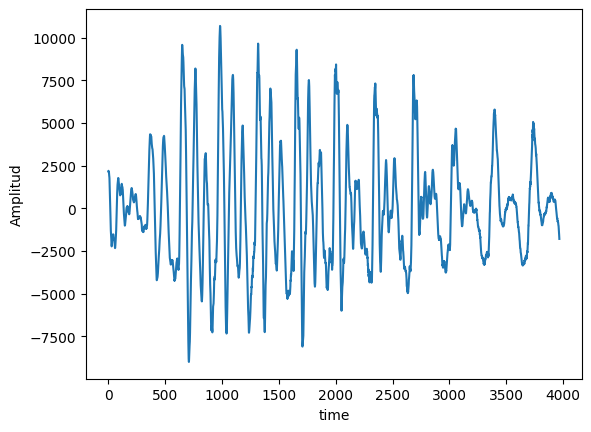

In [204]:
plt.figure()
plt.plot(cut)
plt.title("")
plt.xlabel("time")
plt.ylabel("Amplitud")
plt.show()

Dificil entendre algo. mirem fourier


/home/iticbcn/Escritorio/CE/IA/Virtualsenv/sklearn-env/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/iticbcn/Escritorio/CE/IA/Virtualsenv/sklearn-env/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


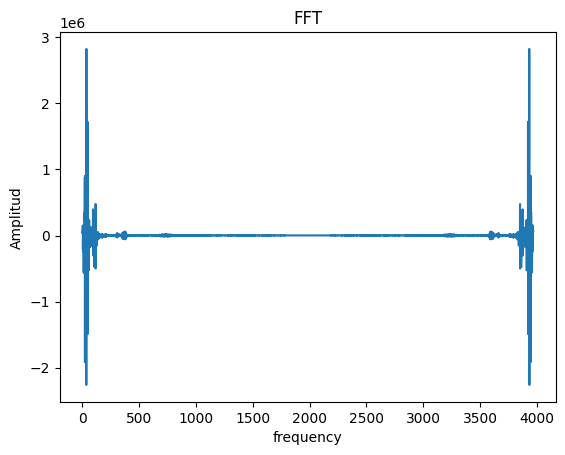

In [205]:
fourier = fft(cut)
plt.figure()
plt.plot(fourier)
plt.title("FFT")
plt.xlabel("frequency")
plt.ylabel("Amplitud")
plt.show()

només m'importa el que pasa a prop de zero


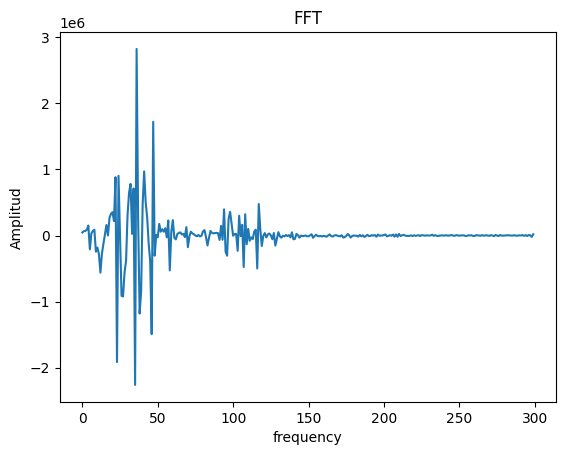

In [206]:
Fsmall = fourier[0:300]
plt.figure()
plt.plot(Fsmall)
plt.title("FFT")
plt.xlabel("frequency")
plt.ylabel("Amplitud")
plt.show()

No m'importa la fase, només el módul.


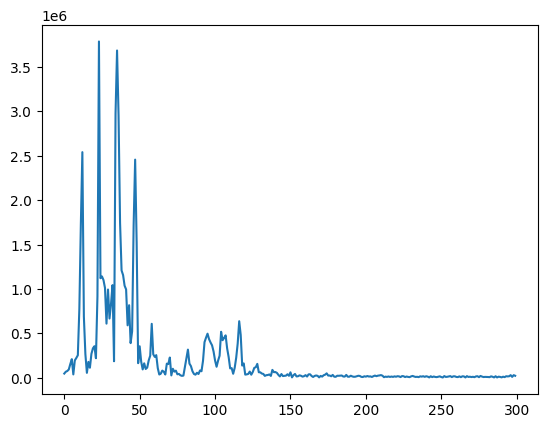

In [207]:
toprocess = np.sqrt((np.real(Fsmall)**2+np.imag(Fsmall)**2))
plt.figure()
plt.plot(toprocess)
plt.show()

Aplico un filtre per quedar eliminar soroll


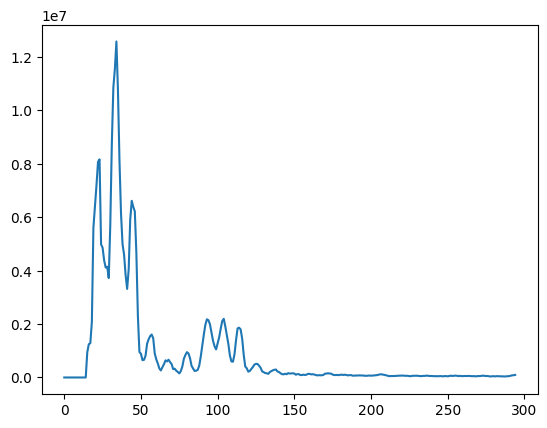

np.int64(34)

In [208]:
filter = 5

def suavitza(toprocess, filter):
    out = np.zeros(len(toprocess)-filter, dtype=np.float64)
    for i in range(len(toprocess)-filter):
        for j in range(filter):
            out[i] += toprocess[i+j]

    out[0:15] = 0
    return out

out= suavitza(toprocess, filter)
        
plt.figure()
plt.plot(out)
plt.show()

np.argmax(out)

50


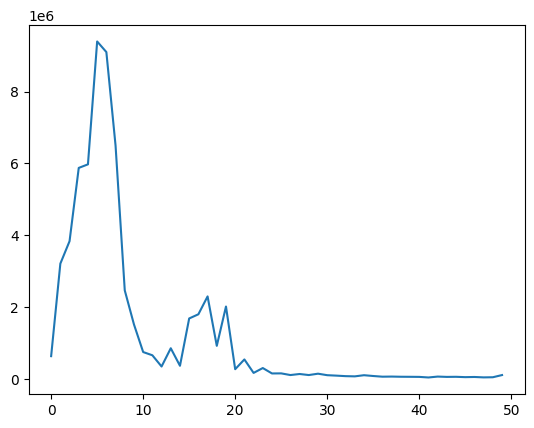

In [209]:
test = toprocess

def resize_fft(fft_audio, muestras_salida, cut_freq):
    y =np.zeros(muestras_salida)
    sample_rate = int(cut_freq/muestras_salida)
    samples_to_take= int(sample_rate*len(fft_audio)/cut_freq)
    #print(samples_to_take)
    for i in range(muestras_salida):
        for j in range(samples_to_take):
            y[i] +=fft_audio[i*samples_to_take+j]
    return y


y=resize_fft(test, 50, 3000)

print(len(y))
plt.figure()
plt.plot(y)
    

In [210]:
#filter2 = int((12*Fs)/fourier.size)
filter2 = 25

print(filter2)

def deletePics(out, filter2):
    maxims=[]
    maxim1 = np.argmax(out)
    
    
    filmin = filter2
    if maxim1 < filter2:
        filmin = maxim1

    out[maxim1-filmin:maxim1+filter2] = 0
    maxims.append(maxim1)
    #plt.figure()
    #plt.plot(out)
    #plt.show()

    
    maxim2 = np.argmax(out)

    out[maxim2-filter2:maxim2+filter2] = 0
    maxims.append(maxim2)
    #plt.figure()
    #plt.plot(out)
    #plt.show()

    maxim3 = np.argmax(out)

    out[maxim3-filter2:maxim3+filter2] = 0
    maxims.append(maxim3)
    #plt.figure()
    #plt.plot(out)
    #plt.show()
    
    return maxims

maxims=deletePics(out, filter2)




25


In [211]:
print(fourier.size)
print(Fs)
print(vowel)
print((maxims[0])*Fs/fourier.size, "Hz")
print((maxims[1])*Fs/fourier.size, "Hz")
print((maxims[2])*Fs/fourier.size, "Hz")


3969
44100
O
377.77777777777777 Hz
1155.5555555555557 Hz
655.5555555555555 Hz


In [212]:
def mostra2freq(N_mostra, Fs, mostres_totals):
    return N_mostra*Fs /mostres_totals
    
    
def freq2Mostra(freq, Fs, mostres_totals):
    return int(freq*mostres_totals /Fs)

Preparando los datos para entrenar el modelo


In [213]:
vowels=[]
X=[]
filtro1 = 180
filtro2 = 220

for select in range(0,len(data)):
    #print(select)
    start = float(data[select]["start"])
    #print(start)
    end=float(data[select]["end"])
    #print(end)
    vowel= data[select]["vocal"]
    #print(vowel)

    Fs, audio = sio.wavfile.read("vowels/jordi.wav")
    cut = audio[int(start*Fs):int(end*Fs)]
  
    vowels.append(vowel)


    fourier = fft(cut)
    Fsmall = fourier[0:freq2Mostra(3000, Fs, len(cut))]
    
    toprocess = np.sqrt((np.real(Fsmall)**2+np.imag(Fsmall)**2))
    
    X.append(resize_fft(toprocess, 150, 3000))
    """
    out=resize_fft(toprocess, 100, 3000)
    out= suavitza(toprocess, freq2Mostra(filtro1, Fs, len(cut)))
    out[0:freq2Mostra(150, Fs, len(cut))] = 0
    
    maxims=deletePics(out, freq2Mostra(filtro2, Fs, len(cut)))
    aux=[]
    
    
    
    aux.append(mostra2freq(maxims[0]-freq2Mostra(filtro1, Fs, len(cut)), Fs, len(cut)))
    aux.append(mostra2freq(maxims[1]-freq2Mostra(filtro1, Fs, len(cut)), Fs, len(cut)))
    aux.append(mostra2freq(maxims[2]-freq2Mostra(filtro1, Fs, len(cut)), Fs, len(cut)))
    #aux.sort()
    #aux=aux[1:]
            
    X.append(aux)
    
    
X = np.array(out)
print(X)
"""

   
    
X = np.array(X)

print(X)
print(vowels)

[[199145.50053909 278061.19460862 877994.37326226 ...  96274.67967635
  131895.79028583 226710.56639125]
 [     0.              0.              0.         ...      0.
       0.              0.        ]
 [ 61316.          52458.56882065  68340.43514275 ...  45964.9365813
   56006.82451171  49476.24562438]
 ...
 [  6642.          16893.7195167   29392.98543231 ...  15244.21048385
    9198.40300479   7393.25338186]
 [     0.              0.              0.         ...      0.
       0.              0.        ]
 [ 43854.          53556.32420291  82662.34612817 ...   2685.43510674
    4040.85935491   7927.37357959]]
['I', 'E', 'A', 'E', 'I', 'A', 'O', 'I', 'E', 'O', 'O', 'A', 'A', 'E', 'U', 'I', 'A', 'A', 'E', 'I', 'A', 'I', 'I', 'A', 'E', 'A', 'E', 'E', 'O', 'U', 'I', 'A', 'E', 'A', 'I', 'E', 'O', 'E', 'O', 'E', 'A', 'E', 'A', 'I', 'E', 'O', 'I', 'A', 'A', 'A', 'E', 'A', 'I', 'E', 'O', 'A', 'I', 'I', 'I', 'E', 'E', 'O', 'U', 'I', 'A', 'O', 'O', 'U', 'O', 'O', 'E', 'E', 'U', 'O', 'A', 'U', 

In [214]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, vowels, test_size=0.1, shuffle=True)



In [215]:
## use a random forest classifier to identify the wines
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC


## Get the accuracy of your model
classifier = SVC()

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(acc)

0.35294117647058826


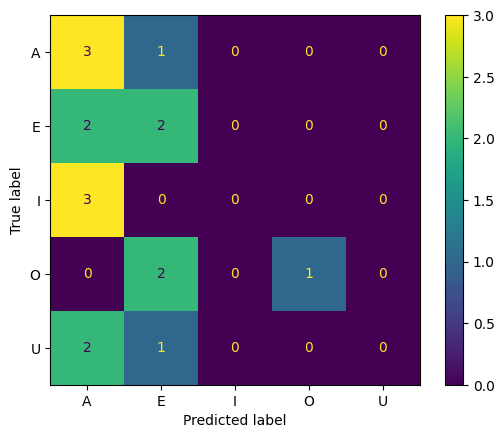

In [216]:
## Display the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test)